# Recommender Evaluation
### By Nicholas Roze-Freitas and Coby Wilcox

## Abstract
~Abstract Goes Here~

## Exploratory data analysis

Before evaluating any recommender frameworks, models or hyperparameters, we will be engaging in exploratory data analysis on the Microsoft News Dataset. The Microsoft news dataset contains 4 separate tab-separated files: behaviors entity_embeddings, news and relation_embeddings. The main focus for now will be on behaviors and news, which gives us data on the catalog and users with interactions.

In [1]:
## IMPORTS ##
import eda_modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


### Changing file formats
We first noticed that our files were in unlabeled .tsv files, to make our data analysis easier in the future these .tsv files were turned into csvs with columns as specified by the datasets github repo. Once these columns were created, exploratory data analysis could be performed more easily.

### Initial understanding
Within the MIND dataset (might want to make it clear that the mind dataset is referring to the microsoft news dataset at some point so that it is more clear to the reader) there are two main files, the behaviors and news. News contains information on the articles that users interact with like its ID, category, sub-category, title, abstract, url and some entities for use within embeddings (to my understanding). Behaviors focuses on impression ids, user ids, time, user history and impressions. Since there are two main datasets, we will be starting with some examination of each, and then examination of how they might interact.

### Starting with news
Starting with the news dataset, we first wanted to check some initial distributions. Out of the news dataset we can check the distributions of categories and sub-categories. Additionally, there is possibility for utilizing the URLs for web-scraping for further text analysis with natural language processing, however this is ICING :D. Visible below is initial distributions for news categories. 

In [2]:
news = pd.read_csv('../MIND_small/csv/news.csv')


In [3]:
fig = eda_modules.plot_sub_categories(news)
fig.show()

[]

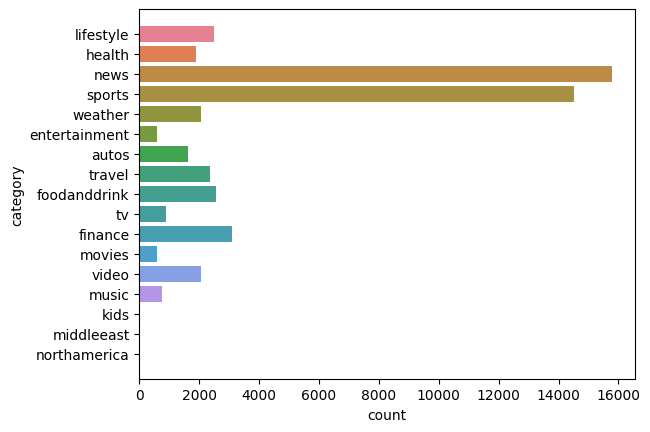

In [4]:
fig = eda_modules.plot_categories(news)
fig.plot()

In [5]:
copynews = news.set_index('news_id')
copynews.loc['N20121']


Unnamed: 0                                                       20003
category                                                         music
sub_category                                                 musicnews
title                   Bob Kingsley, Country Radio Legend, Dead at 80
abstract             Country radio legend Bob Kingley, the longtime...
url                      https://assets.msn.com/labs/mind/AAIW26m.html
title_entities       [{"Label": "Bob Kingsley", "Type": "P", "Wikid...
abstract_entities    [{"Label": "Bob Kingsley", "Type": "P", "Wikid...
Name: N20121, dtype: object

<Axes: xlabel='count', ylabel='category'>

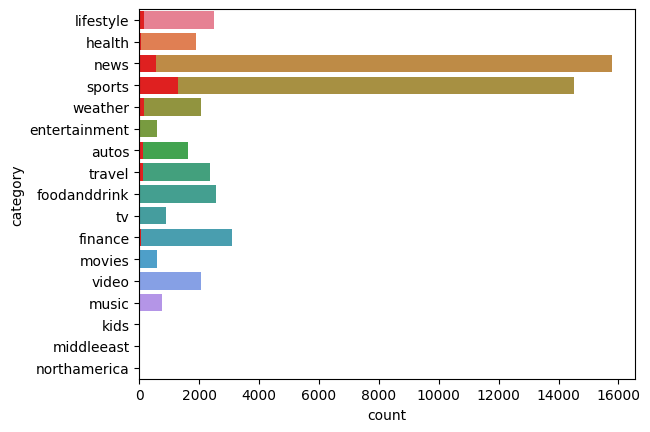

In [6]:
missing_vals = news.isna()
# print(missing_vals.sum())
news[missing_vals['abstract']] # can utilize this as a mask to get values where missing abstract is true in the main, to see if theres a
# majority of missing abstracts for a specific category

sns.countplot(news,y='category',hue='category')
sns.countplot(news[missing_vals['abstract']], color='red',y='category')

In [7]:
behaviors = pd.read_csv('../MIND_small/csv/behaviors.csv')

In [8]:
# print(len(pd.unique(behaviors['user_id'])))
# print(len(behaviors['user_id']))
# print(behaviors.columns)
# print(pd.unique(copynews['sub_category']))

# do missing value analysis on the behaviors csv


In [9]:

from tkinter.tix import PopupMenu


behaviors['time'] = pd.to_datetime(behaviors['time'])

## Gets the most recent time for interactions 
max_idcs = behaviors.groupby('user_id')['time'].idxmax()
max_behaviors = behaviors.loc[max_idcs]
print(max_behaviors['history'].to_list()[:10])
# def swap_to_genres(history):
#     """ 
#     Swaps the articles in a users history to the corresponding genre
#     # """
#     # for interaction in history:
#     # copynews.loc['N55528']['category']

# ## could define a separate function that just creates a new dataframe, updating the column for each genre by 1 for every time an article appears in the maximum history of a user
    
def create_popularity_df():
    """ 
    Creates a dataframe with the popularity of every sub-category and category. The category popularity gets calculated as a biproduct of the sub-category popularity.
    """
    popoularity_dict = {category: 0 for category in pd.unique(copynews['sub_category'])}
    for history in max_behaviors['history']:
        try:
            for news_id in history.split():
                print(news_id)
                sub_category = copynews.loc[news_id]['sub_category']
                popoularity_dict[sub_category] += 1
        except:
            print(history)
            break
    return pd.DataFrame(data=popoularity_dict)

my_dat = create_popularity_df()
my_dat.head()

    
    




['N20121 N33998 N45954 N55743 N50095 N18870 N53465 N42330 N51705 N20575', 'N29641 N1789 N41244', 'N47937 N51706 N56447 N61319 N27644 N18030 N27256 N33976 N34562 N2735 N20639 N22816 N56814 N46444 N59380', 'N39074 N26619 N31431 N1282 N61052 N41668 N50839 N28257', 'N23912 N30148 N46754 N33117 N9619 N36526 N44495 N35304 N45336 N40977 N33876 N60000 N29207 N59704 N32312 N63049 N38870 N52496 N63422 N38390 N10376 N23614 N5812', 'N56253 N37059 N53827 N16290 N31304', 'N52109 N19979 N18551 N9824 N28852 N13374 N50710 N52555 N2003 N40442', 'N38520 N14629 N40772 N63906 N8892 N11894 N59026 N30527 N30765 N58871 N46861 N13404 N5270 N5270 N16655 N65204 N31381 N28257 N53017 N28257', 'N24002 N25292 N1919 N19660', 'N3682 N16605 N61109 N4978 N45778 N41699 N3900']
N20121
N33998
N45954
N55743
N50095
N18870
N53465
N42330
N51705
N20575
N29641
N1789
N41244
N47937
N51706
N56447
N61319
N27644
N18030
N27256
N33976
N34562
N2735
N20639
N22816
N56814
N46444
N59380
N39074
N26619
N31431
N1282
N61052
N41668
N50839
N28257

ValueError: If using all scalar values, you must pass an index

How do we then gauge the most popular genres, or times? 